In [1]:
#!/usr/bin/python

# Import required modules
import os
import sys
sys.path.append('..')
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mpltkr
import matplotlib.colors as mplcolors
import matplotlib.patches as mplpatches
import matplotlib.lines as mpllines
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Utilities
from tools import load_json
import project_utils as utils
import h5py

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Initial setup

In [2]:
# Load SOAP cutoffs
soap_hyperparameters = load_json('../../Processed_Data/soap_hyperparameters.json')   
cutoffs = soap_hyperparameters['interaction_cutoff']

In [3]:
# Load train and test set indices for Deem
deem_train_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/train.idxs', dtype=int)
deem_test_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/test.idxs', dtype=int)
n_deem_train = len(deem_train_idxs)
n_deem_test = len(deem_test_idxs)

In [4]:
# Load train and test set indices for IZA
iza_train_idxs = np.loadtxt('../../Processed_Data/IZA_226/train.idxs', dtype=int)
iza_test_idxs = np.loadtxt('../../Processed_Data/IZA_226/test.idxs', dtype=int)

In [5]:
# Load IZA cantons
iza_cantons = np.loadtxt('../../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
n_iza = len(iza_cantons)

# Linear regression of molar volumes and energies

In [6]:
deem_dir = '../../Processed_Data/DEEM_330k/Data'
iza_dir = '../../Processed_Data/IZA_226/Data'

In [7]:
# Set property names for loading
property_names = ['volumes', 'energies']

# Load structure properties
deem_structure_properties = {}
deem_predicted_structure_properties = {}

iza_structure_properties = {}
iza_predicted_structure_properties = {}
for pn in property_names:
    property_label = pn.capitalize()
    
    deem_structure_properties[pn] = np.loadtxt(f'{deem_dir}/structure_{pn}.dat')
    iza_structure_properties[pn] = np.loadtxt(f'{iza_dir}/structure_{pn}.dat')
    
for cutoff in cutoffs:
    deem_predicted_structure_properties[cutoff] = {}
    iza_predicted_structure_properties[cutoff] = {}
    for pn in property_names:
        property_label = pn.capitalize()
        
        deem_predicted_structure_properties[cutoff][pn] = \
            np.loadtxt(f'{deem_dir}/{cutoff}/Linear_Models/LR/{property_label}/lr_structure_properties.dat')
        
        iza_predicted_structure_properties[cutoff][pn] = \
            np.loadtxt(f'{iza_dir}/{cutoff}/Linear_Models/LR/{property_label}/lr_structure_properties.dat')

In [8]:
# BEGIN TMP

In [9]:
# Load train and test set indices for Deem
# Train and test sets (random DEEM)
from numpy.random import default_rng
idxs_delete = np.loadtxt('../../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)
deem_10k_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/deem_10k.idxs', dtype=int)

n_total = 331172
n_train = 10000
n_test = 250
rng = default_rng(seed=11011)
idxs = np.arange(0, n_total)
idxs = np.delete(idxs, idxs_delete)
rng.shuffle(idxs)
deem_train_idxs = idxs[0:n_train]
deem_test_idxs = idxs[n_train:n_train + n_test]

In [10]:
for cutoff in cutoffs:
    for pn in property_names:
        property_label = pn.capitalize()
        print(f'-----Error for {cutoff} {property_label}-----')
        print('DATASET | n_train | n_test | train_error | test_error')
        
        deem_train_error = mean_absolute_error(
            deem_structure_properties[pn][deem_train_idxs],
            deem_predicted_structure_properties[cutoff][pn][deem_train_idxs]
        )
        deem_test_error = mean_absolute_error(
            deem_structure_properties[pn][deem_test_idxs],
            deem_predicted_structure_properties[cutoff][pn][deem_test_idxs]
        )
        
        iza_test_error = mean_absolute_error(
            iza_structure_properties[pn],
            iza_predicted_structure_properties[cutoff][pn]
        )
        
        print(f'DEEM:\t{n_deem_train}\t{n_deem_test}\t{deem_train_error:.2f}\t{deem_test_error:.2f}')
        print(f'IZA:\t--\t{n_iza}\t--\t{iza_test_error:.2f}')
        print('')
        
        for canton in range(1, np.amax(iza_cantons)+1):
            canton_idxs = np.nonzero(iza_cantons == canton)[0]
            canton_test_error = mean_absolute_error(
                iza_structure_properties[pn][canton_idxs],
                iza_predicted_structure_properties[cutoff][pn][canton_idxs]
            )
            
            print(f'IZA{canton}:\t--\t{len(canton_idxs)}\t--\t{canton_test_error:.2f}')
            
        print('')

-----Error for 3.5 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	2.47	2.40
IZA:	--	226	--	6.44

IZA1:	--	35	--	7.23
IZA2:	--	122	--	6.17
IZA3:	--	68	--	5.87
IZA4:	--	1	--	50.39

-----Error for 3.5 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.63	0.64
IZA:	--	226	--	1.09

IZA1:	--	35	--	1.35
IZA2:	--	122	--	1.02
IZA3:	--	68	--	1.02
IZA4:	--	1	--	4.51

-----Error for 6.0 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	1.05	1.05
IZA:	--	226	--	1.59

IZA1:	--	35	--	0.83
IZA2:	--	122	--	1.46
IZA3:	--	68	--	1.79
IZA4:	--	1	--	31.28

-----Error for 6.0 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.09	0.11
IZA:	--	226	--	0.32

IZA1:	--	35	--	0.47
IZA2:	--	122	--	0.29
IZA3:	--	68	--	0.24
IZA4:	--	1	--	3.77



In [ ]:
# END TMP

In [12]:
for cutoff in cutoffs:
    for pn in property_names:
        property_label = pn.capitalize()
        print(f'-----Error for {cutoff} {property_label}-----')
        print('DATASET | n_train | n_test | train_error | test_error')
        
        deem_train_error = mean_absolute_error(
            deem_structure_properties[pn][deem_train_idxs],
            deem_predicted_structure_properties[cutoff][pn][deem_train_idxs]
        )
        deem_test_error = mean_absolute_error(
            deem_structure_properties[pn][deem_test_idxs],
            deem_predicted_structure_properties[cutoff][pn][deem_test_idxs]
        )
        
        iza_test_error = mean_absolute_error(
            iza_structure_properties[pn],
            iza_predicted_structure_properties[cutoff][pn]
        )
        
        print(f'DEEM:\t{n_deem_train}\t{n_deem_test}\t{deem_train_error:.2f}\t{deem_test_error:.2f}')
        print(f'IZA:\t--\t{n_iza}\t--\t{iza_test_error:.2f}')
        print('')
        
        for canton in range(1, np.amax(iza_cantons)+1):
            canton_idxs = np.nonzero(iza_cantons == canton)[0]
            canton_test_error = mean_absolute_error(
                iza_structure_properties[pn][canton_idxs],
                iza_predicted_structure_properties[cutoff][pn][canton_idxs]
            )
            
            print(f'IZA{canton}:\t--\t{len(canton_idxs)}\t--\t{canton_test_error:.2f}')
            
        print('')

-----Error for 3.5 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	2.40	2.79
IZA:	--	226	--	6.80

IZA1:	--	35	--	7.47
IZA2:	--	122	--	6.68
IZA3:	--	68	--	6.11
IZA4:	--	1	--	44.90

-----Error for 3.5 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.61	0.66
IZA:	--	226	--	1.35

IZA1:	--	35	--	1.73
IZA2:	--	122	--	1.27
IZA3:	--	68	--	1.09
IZA4:	--	1	--	15.81

-----Error for 6.0 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	1.02	1.12
IZA:	--	226	--	1.65

IZA1:	--	35	--	0.90
IZA2:	--	122	--	1.52
IZA3:	--	68	--	1.84
IZA4:	--	1	--	30.86

-----Error for 6.0 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.08	0.11
IZA:	--	226	--	0.31

IZA1:	--	35	--	0.46
IZA2:	--	122	--	0.28
IZA3:	--	68	--	0.24
IZA4:	--	1	--	4.24



## DEEM 330k analysis

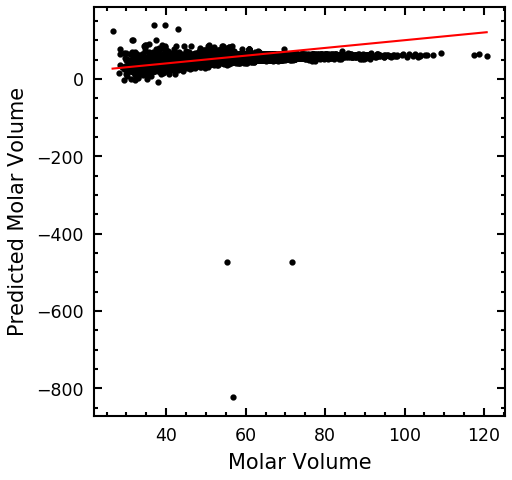

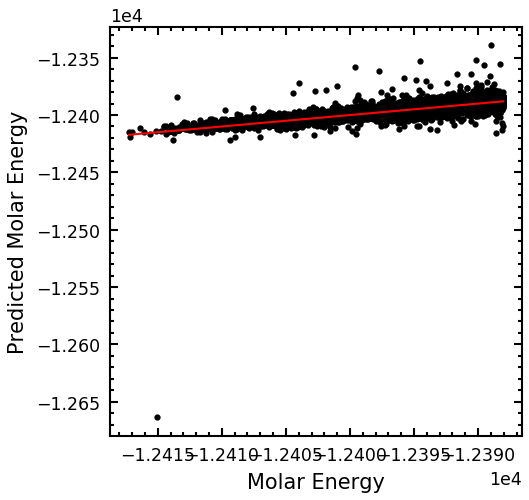

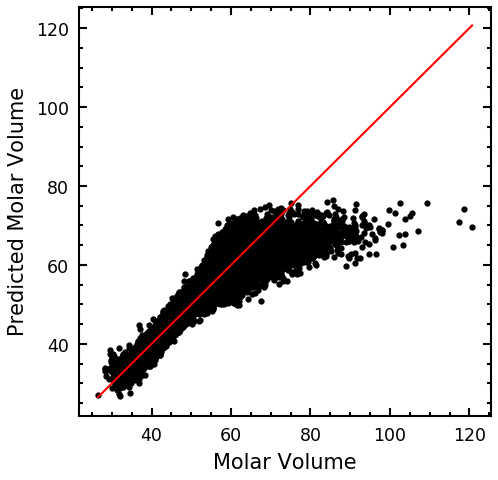

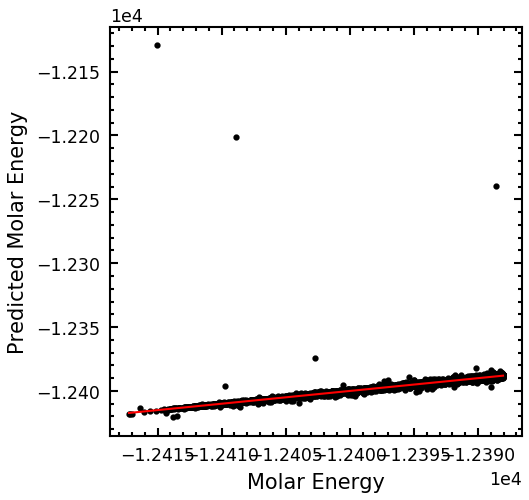

In [27]:
for cutoff in cutoffs:
    for pn, label in zip(property_names, ('Volume', 'Energy')):
        plt.scatter(
            deem_structure_properties[pn], 
            deem_predicted_structure_properties[cutoff][pn]
        )
        plt.plot(
            [
                deem_structure_properties[pn].min(), 
                deem_structure_properties[pn].max()
            ], 
            [
                deem_structure_properties[pn].min(), 
                deem_structure_properties[pn].max()
            ], 
            c='r'
        )
        plt.xlabel(f'Molar {label}')
        plt.ylabel(f'Predicted Molar {label}')
        plt.show()

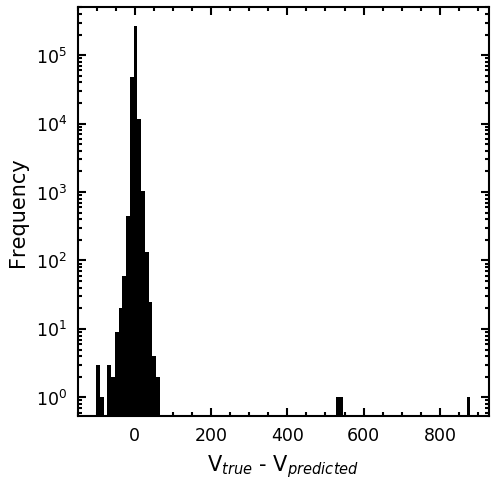

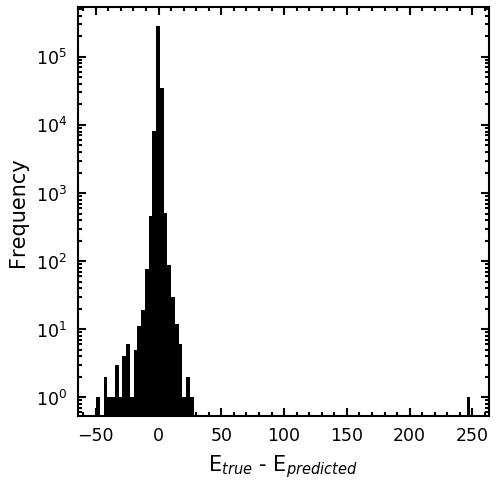

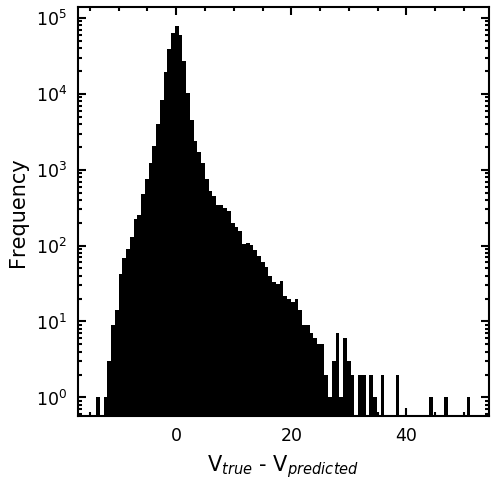

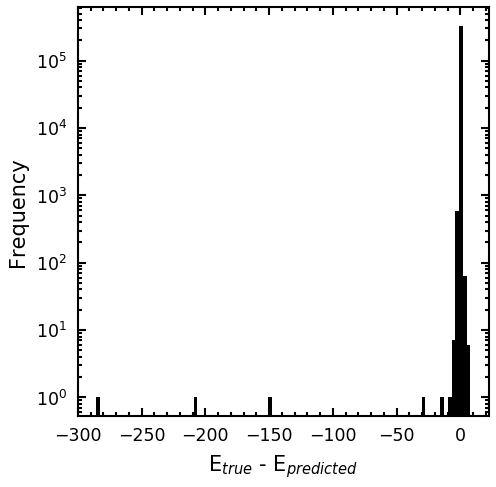

In [21]:
for cutoff in cutoffs:
    for pn in property_names:
        plt.hist(
            deem_structure_properties[pn] - deem_predicted_structure_properties[cutoff][pn],
            bins=100, density=False, log=True
        )
        label = pn.capitalize()[0]
        plt.xlabel(fr'{label}$_{{true}}$ - {label}$_{{predicted}}$')
        plt.ylabel('Frequency')
        plt.show()

In [52]:
deem_codes = np.arange(0, len(deem_structure_properties['volumes'])) + 8000001

In [56]:
n_show = 100
for cutoff in cutoffs:
    for pn in property_names:
        errors = np.abs(deem_structure_properties[pn] -  deem_predicted_structure_properties[cutoff][pn])
        idxs = np.argsort(errors)
        print(f'-----Abs. errors for {cutoff} {pn.capitalize()}-----')
        for e, c in zip(errors[idxs][-n_show:], deem_codes[idxs][-n_show:]):
            print(f'{c}\t\t{e}')
        print('')

-----Errors for 3.5 Volumes-----
8324634		32.215481768749356
8307691		32.45538255639626
8318835		32.6356661463285
8307129		32.68104183078877
8321582		32.68984810106459
8329775		32.714420966887474
8261270		32.79147678297242
8200851		33.0256033715235
8046537		33.02802393459646
8320054		33.13288301558797
8323191		33.151739452898184
8320103		33.16940329572528
8037824		33.31612252980561
8200684		33.47416783112036
8327293		33.58524377202335
8196363		33.63321775207347
8129588		33.658383360512445
8319194		33.767856618860264
8123092		33.856314894144845
8327476		33.870308304918176
8326900		34.17348481188261
8292630		34.36041504449176
8035077		34.39739202734363
8035680		34.56925529362993
8081127		34.80725678039857
8011687		34.835826256639855
8200794		35.06581412244861
8315654		35.20359349059272
8329781		35.64336244156488
8137257		35.68858974789288
8322015		35.722712218553255
8140702		35.74070996492783
8042929		35.7999192409783
8023277		35.88428848624228
8067892		35.99281045040541
8327563		36.1717

In [60]:
deem_10k_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/deem_10k.idxs', dtype=int)
deem_delete_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)

In [64]:
for cutoff in cutoffs:
    for pn in property_names:
        errors = np.abs(deem_structure_properties[pn] - deem_predicted_structure_properties[cutoff][pn])
        mean_error = np.mean(errors)
        std_error = np.std(errors)
        print(f'-----Problem structures for {cutoff} {pn}-----')
        for i in range(1, 11):
            idxs_high = np.nonzero(errors >= mean_error + i * std_error)[0]
            idxs_low = np.nonzero(errors <= mean_error - i * std_error)[0]
            idxs_all = np.concatenate((idxs_low, idxs_high))
            in_deem_10k = np.intersect1d(deem_10k_idxs, idxs_all)
            in_deem_delete = np.intersect1d(deem_delete_idxs, idxs_all)
            for idxs in (idxs_all, in_deem_10k, in_deem_delete):
                idxs += 8000001
            print(f'{i}-sigma ({len(idxs_all)}, {len(in_deem_delete)}, {len(in_deem_10k)})')
            print(idxs_all)
        print('')

-----Problem structures for 3.5 volumes-----
1-sigma (27189, 4, 674)
[8000012 8000022 8000028 ... 8331161 8331163 8331164]
2-sigma (7942, 3, 178)
[8000012 8000028 8000070 ... 8331136 8331156 8331164]
3-sigma (3329, 3, 73)
[8000028 8000070 8002048 ... 8331112 8331120 8331121]
4-sigma (1669, 3, 46)
[8002603 8002828 8003364 ... 8331020 8331110 8331121]
5-sigma (829, 3, 19)
[8002828 8003364 8004176 8006495 8009060 8011687 8013559 8014803 8019256
 8020212 8020459 8021495 8022741 8022958 8023031 8023277 8024778 8025486
 8027973 8028083 8028375 8035077 8035078 8035680 8035701 8035895 8035976
 8037822 8037824 8037968 8038078 8038164 8038300 8038314 8039972 8040073
 8042525 8042929 8045577 8045578 8045580 8046537 8048032 8051227 8051583
 8054009 8054159 8054161 8055999 8056798 8056809 8056820 8056830 8056864
 8059332 8059343 8059483 8059484 8059805 8059807 8060366 8060369 8062817
 8062865 8063080 8067656 8067891 8067892 8067893 8067909 8068089 8068112
 8068115 8068129 8069913 8077929 8078021 80

## IZA 226 analysis

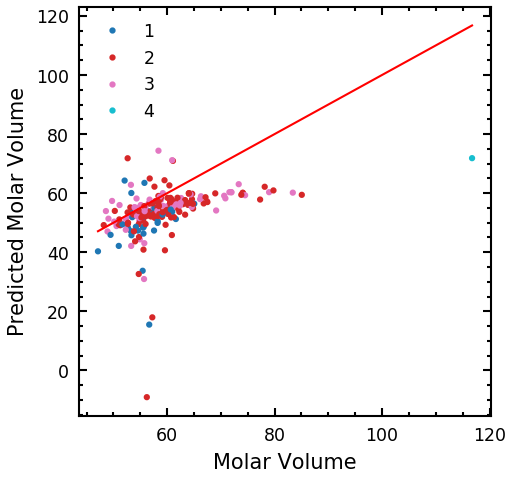

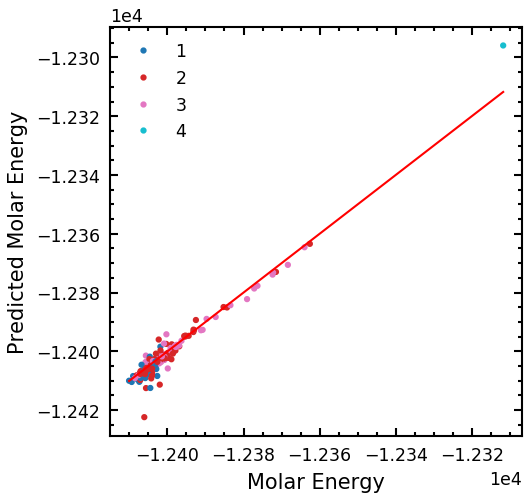

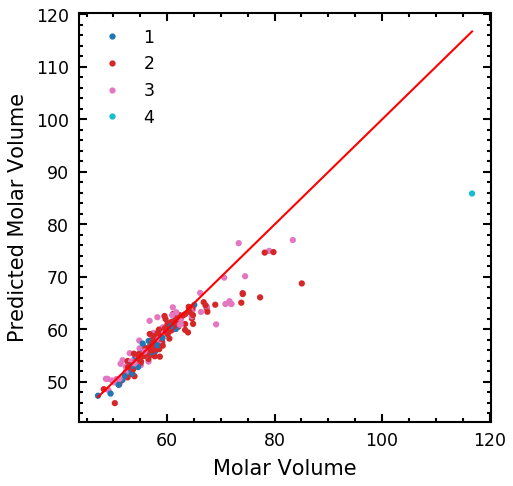

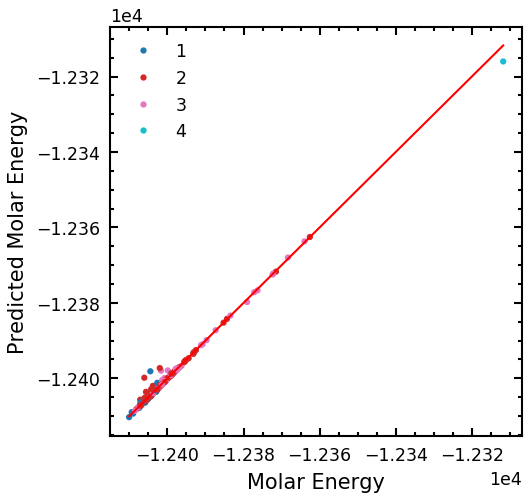

In [36]:
for cutoff in cutoffs:
    for pn, label in zip(property_names, ('Volume', 'Energy')):
        scatter = plt.scatter(
            iza_structure_properties[pn], 
            iza_predicted_structure_properties[cutoff][pn],
            c=iza_cantons, cmap='tab10'
        )
        plt.plot(
            [
                iza_structure_properties[pn].min(), 
                iza_structure_properties[pn].max()
            ], 
            [
                iza_structure_properties[pn].min(), 
                iza_structure_properties[pn].max()
            ], 
            c='r'
        )
        plt.xlabel(f'Molar {label}')
        plt.ylabel(f'Predicted Molar {label}')
        plt.legend(*scatter.legend_elements())
        plt.show()

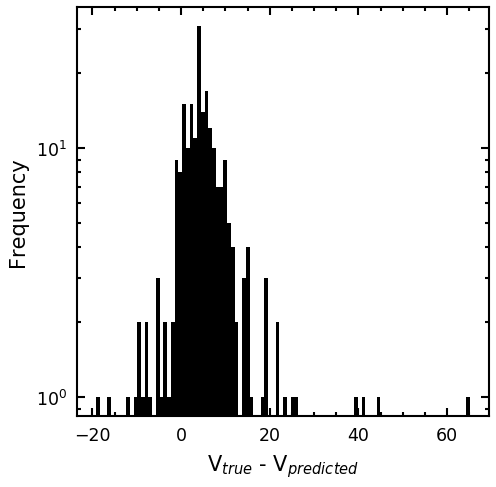

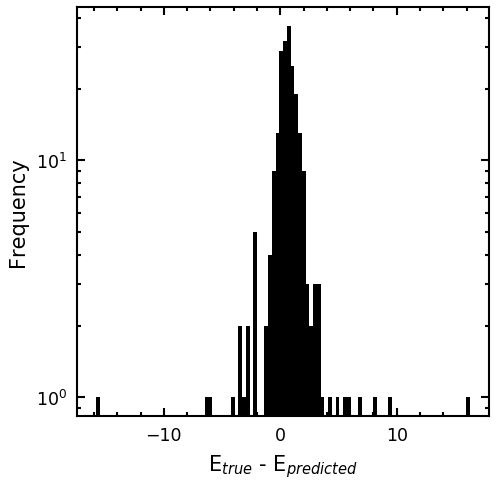

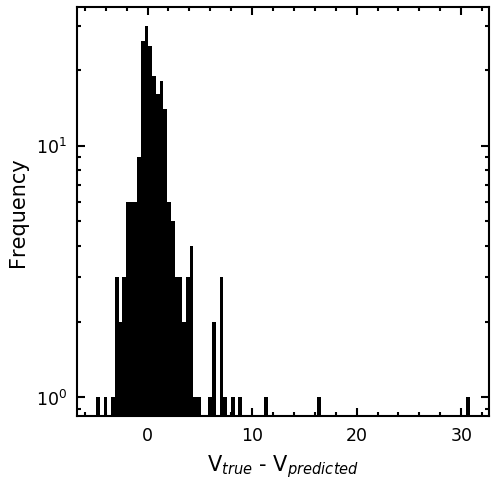

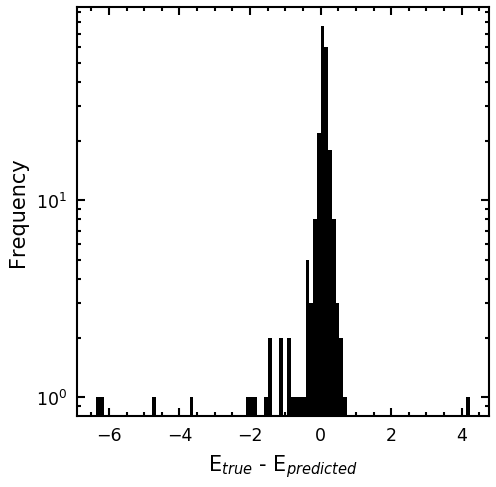

In [23]:
for cutoff in cutoffs:
    for pn in property_names:
        plt.hist(
            iza_structure_properties[pn] - iza_predicted_structure_properties[cutoff][pn],
            bins=100, density=False, log=True
        )
        label = pn.capitalize()[0]
        plt.xlabel(fr'{label}$_{{true}}$ - {label}$_{{predicted}}$')
        plt.ylabel('Frequency')
        plt.show()

In [39]:
iza_codes = np.loadtxt('../../Raw_Data/GULP/IZA_226/cantons.txt', usecols=0, dtype=str)

In [58]:
for cutoff in cutoffs:
    for pn in property_names:
        errors = np.abs(iza_structure_properties[pn] -  iza_predicted_structure_properties[cutoff][pn])
        idxs = np.argsort(errors)
        print(f'-----Abs. errors for {cutoff} {pn.capitalize()}-----')
        for e, c, cc in zip(errors[idxs], iza_cantons[idxs], iza_codes[idxs]):
            print(f'{c}\t{cc[0:3]}\t{e}')
        print('')

-----Abs. errors for 3.5 Volumes-----
1	ETL	0.0026870177488547142
3	ATT	0.02293065177628506
2	JBW	0.03690006073421159
2	BRE	0.042457611901546954
2	VNI	0.10814834078923496
3	SIV	0.14341523258217848
3	JNT	0.2261271563109446
2	MRT	0.23070774312751752
2	PHI	0.3506559694313651
2	MOZ	0.5076517523741444
3	AHT	0.6014413537205456
3	DFT	0.6698563529661214
2	GIS	0.6883886291085446
3	POR	0.7727503872019952
2	SOR	0.7740845750708374
2	SZR	0.793593235776413
3	ATN	0.8014716139438249
3	CGS	0.8132695495276039
2	STI	0.8393508663762219
3	BOF	0.8415823494865862
2	LTJ	0.8489232654556673
2	MSO	0.8636919032200012
2	MON	0.8787842284393079
3	APC	0.8929245076725394
2	LTL	0.9042802396164831
2	MVY	1.0006921368458208
3	JRY	1.02833952820707
3	ACO	1.0365271455148815
3	APD	1.075871691558497
3	NPO	1.094989742557658
3	UEI	1.2715018332212153
2	ABW	1.2830172560352935
3	AWO	1.313039624545283
2	CAS	1.495752342417127
1	CDO	1.6426047422624706
2	DAC	1.645451535451528
2	MWF	1.6558435974272783
3	ATV	1.695858328124622
3	PSI	1.861